In [27]:
from os import walk
import socket
if socket.gethostname() == 'jim-Mint':
    ppi_path = '/home/jim/src/p39/fftanalysis/test_systems'
    home = '/home/jim'
elif socket.gethostname() == 'host252.ent.iit.edu':
    ppi_path = '/home/jtufts/Downloads/test_systems'
    home = '/home/jtufts'
else:
    ppi_path = '/home/jtufts/src/p39/fftanalysis/test_systems'
    home = '/home/jtufts'

In [28]:
f = {}
for (dirpath, dirnames, filenames) in walk(f'{ppi_path}/2.redock/2.minimize'):
    if len(filenames) > 0:
        if filenames[0] != 'run_me.sh':
            if 'ligand.inpcrd' in filenames:
                f[dirpath.split('/')[9]] = dirpath + '/ligand.inpcrd'

In [29]:
keys = list(f.keys())
keys.sort()
system = keys[1] #36 
print(system, f[system])

2OOB_A:B /home/jim/src/p39/fftanalysis/test_systems/2.redock/2.minimize/2OOB_A:B/ligand.inpcrd


In [30]:
from bpmfwfft.IO import InpcrdLoad
from bpmfwfft.grids import Grid, RecGrid
import numpy as np


def _distance(coord1, coord2):
    assert len(coord1)==len(coord1)==3, "coord must have len 3"
    d = np.array(coord1) - np.array(coord2)
    d = (d**2).sum()
    return np.sqrt(d)


def _max_inter_atom_distance(inpcrd):
    """
    inpcrd: str, name of inpcrd file
    """
    crd = InpcrdLoad(inpcrd).get_coordinates()
    max_d = 0.
    for i in range(crd.shape[0]-1):
        for j in range(i+1, crd.shape[0]):
            d = _distance(crd[i], crd[j])
            if d > max_d:
                max_d = d
    return max_d


def _max_box_edge(inpcrd):
    """
    """
    crd = InpcrdLoad(inpcrd).get_coordinates()
    dx = crd[:,0].max() - crd[:,0].min()
    dy = crd[:,1].max() - crd[:,1].min()
    dz = crd[:,2].max() - crd[:,2].min()
    return max([dx, dy, dz])


def rec_grid_cal(prmtop, lj_scale, sc_scale, ss_scale, sm_scale, rho,
                 rec_inpcrd, lig_inpcrd, spacing, buffer,
                 grid_out, pdb_out, box_out, radii_type, exclude_H):
    """
    prmtop: str, prmtop file for receptor
    lj_scale:   float, 0 < lj_scale <=1
    rc_scale:   float, 0 < rc_scale
    rs_scale:   float, 0 < rs_scale
    rm_scale:   float, 0 < rm_scale
    rec_inpcrd: str, inpcrd file for receptor
    lig_inpcrd: str, inpcrd file for ligand, used to determine grid size
    spacing:    float, distance between grid points in Angstroms
    buffer:     float, extra box padding
    grid_out:   str, name of output nc file
    pdb_out:    str, name of output pdb file
    box_out:    str, name of output box
    radii_type: str, name of radii to use, LJ_SIGMA or VDW_RADII
    exclude_H:  bool, exclude hydrogen from grid calculation
    """
    #ligand_max_size = _max_inter_atom_distance(lig_inpcrd)
    #print "Ligand maximum inter-atomic distance: %f"%ligand_max_size

    ligand_max_box_edge = _max_box_edge(lig_inpcrd)
    print("Ligand maximum box edge: %f" % ligand_max_box_edge)
    total_buffer = np.ceil(ligand_max_box_edge + buffer)
    print("Total buffer for receptor grid: %f" % total_buffer)

    bsite_file = None
    potential_grid = RecGrid(prmtop,
                             lj_scale,
                             sc_scale,
                             ss_scale,
                             sm_scale,
                             rho,
                             rec_inpcrd,
                             bsite_file,
                             grid_out,
                             new_calculation=True,
                             spacing=spacing,
                             extra_buffer=total_buffer,
                             radii_type=radii_type,
                             exclude_H=exclude_H)
    # potential_grid = RecGrid(prmtop, lj_scale, sc_scale, ss_scale, rho, rec_inpcrd, bsite_file, grid_out, new_calculation=True, spacing=spacing, )

    potential_grid.write_pdb(pdb_out, "w")
    potential_grid.write_box(box_out)

    return None


def is_nc_grid_good(nc_grid_file):
    if not os.path.exists(nc_grid_file):
        return False

    if os.path.getsize(nc_grid_file) == 0:
        return False

    nc_handle = netCDF4.Dataset(nc_grid_file, "r")
    nc_keys = nc_handle.variables.keys()
    grid_keys = Grid().get_allowed_keys()
    for key in grid_keys:
        if key not in nc_keys:
            return False
    return True


def get_grid_size_from_nc(grid_nc_file):
    nc_handle = netCDF4.Dataset(grid_nc_file, "r")
    return nc_handle.variables["counts"][0]


def get_grid_size_from_lig_rec_crd(rec_inpcrd, lig_inpcrd, buffer):
    ligand_max_box_edge = _max_box_edge(lig_inpcrd)
    buffer_due_to_ligand = np.ceil(ligand_max_box_edge + buffer)
    box_size = _max_box_edge(rec_inpcrd) +  2.0*buffer_due_to_ligand
    return box_size

In [ ]:
prmtop = f"{ppi_path}/2.redock/1.amber/{system}/receptor.prmtop"
lj_scale = 1.0
rc_scale = 0.76
rs_scale = 0.53
rm_scale = 0.55
rec_inpcrd = f"{ppi_path}/2.redock/2.minimize/{system}/receptor.inpcrd"
lig_inpcrd = f"{ppi_path}/2.redock/2.minimize/{system}/ligand.inpcrd"
rho = 9.0
exclude_H = True

spacing = 0.5
buffer = 1
radii_type = "VDW_RADII"

grid_out = f"{ppi_path}/2.redock/4.receptor_grid/{system}/grid.nc"
pdb_out = f"{ppi_path}/2.redock/4.receptor_grid/{system}/receptor_trans.pdb"
box_out = f"{ppi_path}/2.redock/4.receptor_grid/{system}/box.pdb"

rec_grid_cal(prmtop, lj_scale, rc_scale, rs_scale, rm_scale, rho,
             rec_inpcrd, lig_inpcrd, spacing, buffer, grid_out, pdb_out, box_out, radii_type, exclude_H)

In [31]:
%%time
import netCDF4 as nc
import numpy as np
grid_name = "grid.nc"
grid_path = f'{ppi_path}/2.redock/4.receptor_grid/{system}'
print(grid_path)
grid_nc = '%s/%s'%(grid_path,grid_name)


#parsing some of the netcdf variables from grid.nc
grid_variables = nc.Dataset(grid_nc, 'r').variables
counts = nc.Dataset(grid_nc, 'r').variables["counts"][:]
x = nc.Dataset(grid_nc, 'r').variables["x"][:]
y = nc.Dataset(grid_nc, 'r').variables["y"][:]
z = nc.Dataset(grid_nc, 'r').variables["z"][:]
electrostatic = nc.Dataset(grid_nc, 'r').variables["electrostatic"][:]
lja = nc.Dataset(grid_nc, 'r').variables["LJa"][:]
ljr = nc.Dataset(grid_nc, 'r').variables["LJr"][:]
sasa = nc.Dataset(grid_nc, 'r').variables["sasa"][:]
occupancy = nc.Dataset(grid_nc, 'r').variables["occupancy"][:]
trans_crd = nc.Dataset(grid_nc, 'r').variables["trans_crd"][:]
rec_disp = nc.Dataset(grid_nc, 'r').variables["displacement"][:]

/home/jim/src/p39/fftanalysis/test_systems/2.redock/4.receptor_grid/2OOB_A:B
CPU times: user 58.1 ms, sys: 64.6 ms, total: 123 ms
Wall time: 123 ms


In [32]:
%%time
from bpmfwfft.grids import RecGrid
from bpmfwfft.grids import LigGrid
import netCDF4 as nc

rec_prmtop = f"{ppi_path}/2.redock/1.amber/{system}/receptor.prmtop"
lj_sigma_scal_fact = 1.0
rec_inpcrd = f"{ppi_path}/2.redock/2.minimize/{system}/receptor.inpcrd"

bsite_file = None
grid_nc_file = f"{ppi_path}/2.redock/4.receptor_grid/{system}/grid.nc"

lig_prmtop = f"{ppi_path}/2.redock/1.amber/{system}/ligand.prmtop"
# lig_inpcrd = f"{ppi_path}/2.redock/2.minimze/2OOB_A:B/ligand.inpcrd"

# rot_nc = f"{ppi_path}/2.redock/3.ligand_rand_rot/{system}/trajectory.nc"
# lig_rot = nc.Dataset(rot_nc, 'r').variables['positions']
lig_inpcrd = f"{ppi_path}/2.redock/2.minimize/{system}/ligand.inpcrd"

rho = 9.0
rc_scale = 0.76
rs_scale = 0.53
rm_scale = 0.55
lc_scale = 0.81
ls_scale = 0.50
lm_scale = 0.54


def _create_rec_grid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, grid_nc_file):
    rec_grid = RecGrid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, 
                        grid_nc_file, new_calculation=False)
    return rec_grid

def _create_lig_grid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid):
    lig_grid = LigGrid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid)
    return lig_grid

rec_grid = _create_rec_grid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, grid_nc_file)

lig_grid = _create_lig_grid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid)
# rot_num = 0
# lig_grid._crd = np.array(lig_rot[rot_num], dtype=np.float64)
lig_grid._move_ligand_to_lower_corner()

[1.]
/home/jim/src/p39/fftanalysis/test_systems/2.redock/4.receptor_grid/2OOB_A:B/grid.nc
x
[  0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5
   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5
  12.   12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5
  18.   18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5
  24.   24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5
  30.   30.5  31.   31.5  32.   32.5  33.   33.5  34.   34.5  35.   35.5
  36.   36.5  37.   37.5  38.   38.5  39.   39.5  40.   40.5  41.   41.5
  42.   42.5  43.   43.5  44.   44.5  45.   45.5  46.   46.5  47.   47.5
  48.   48.5  49.   49.5  50.   50.5  51.   51.5  52.   52.5  53.   53.5
  54.   54.5  55.   55.5  56.   56.5  57.   57.5  58.   58.5  59.   59.5
  60.   60.5  61.   61.5  62.   62.5  63.   63.5  64.   64.5  65.   65.5
  66.   66.5  67.   67.5  68.   68.5  69.   69.5  70.   70.5  71.   71.5
  72.   72.5  73.   73.5  74.   

In [59]:
%%time
# names = ["occupancy", "sasa", "electrostatic", "LJa", "LJr", "water"]
# names = ["occupancy", "LJa", "LJr"]
names = ["LJr"]
# lgrid = lig_grid.get_ligand_grids(names, [0,0,0])
vect = [91,90,120]*lig_grid._spacing
lgrid = lig_grid.get_ligand_grids(names, vect)

calculating Ligand LJr grid


RuntimeError: Atom is outside the grid

In [ ]:
# direct grid pairwise multiplication vs fft energy test
print(np.sum(lgrid["LJr"]*ljr))

lljr_fft = np.fft.fftn(lgrid["LJr"])
rljr_fft = rec_grid._FFTs["LJr"]
ljr_energy = np.fft.ifftn(rljr_fft * lljr_fft.conjugate())
ljr_energy = np.real(ljr_energy)
print(ljr_energy[0,0,0])
print(ljr_energy[91,90,120])

print(np.where(ljr_energy == ljr_energy.min()))

In [14]:
print(np.min(ljr), lgrid["LJr"].min())
print(lig_grid._prmtop.keys())
print(lig_grid._prmtop["R_LJ_CHARGE"].max())
print((np.array(np.where(lgrid["LJr"] < -30.0)).T)*lig_grid._spacing)
di = []
for acrd in lig_grid._crd:
    d = _distance(acrd, np.array([71.5,58.5,83.5]))
    if d < 2.0:
        di.append(np.array(np.where(lig_grid._crd == acrd)).T[0][0])
print(di)
print(lig_grid._prmtop["PDB_TEMPLATE"].keys())
for id in di:
    print(lig_grid._prmtop["PDB_TEMPLATE"]["ATOM_NAME"][id], lig_grid._prmtop["R_LJ_CHARGE"][id])
cai = [index for index, value in enumerate(lig_grid._prmtop["PDB_TEMPLATE"]["ATOM_NAME"]) if value == 'CA']
print(lig_grid._prmtop["R_LJ_CHARGE"][136])
print(cai)
print(np.where(lig_grid._prmtop["R_LJ_CHARGE"]<1))
print(lig_grid._prmtop["PDB_TEMPLATE"]["ATOM_NAME"][774])
for index in [0,4,50,52,9,10,60,112,62,112,193,199]:
    print(lig_grid._prmtop["PDB_TEMPLATE"]["ATOM_NAME"][index] , lig_grid._prmtop["R_LJ_CHARGE"][index], lig_grid._crd[index]) 
print(lig_grid._prmtop["R_LJ_CHARGE"].mean())

1.476645123333827e-18 -247.9238358100112
dict_keys(['CHARGE_E_UNIT', 'R_LJ_CHARGE', 'A_LJ_CHARGE', 'LJ_SIGMA', 'LJ_EPSILON', 'VDW_RADII', 'POINTERS', 'MASS', 'PDB_TEMPLATE'])
2047.9999999999986
[[49.  66.  72. ]
 [49.5 66.  71. ]
 [49.5 66.  71.5]
 ...
 [82.  51.  80.5]
 [82.  51.  82. ]
 [82.  51.5 92. ]]
[132, 134, 135, 136, 137, 138, 142]
dict_keys(['ATOM_NAME', 'RES_NAME', 'RES_ORDER'])
C 905.5228666356246
N 971.7475150469897
H 0.3741427227676624
CA 1021.3129931612534
HA 57.09374965790913
CB 1021.3129931612534
C 905.5228666356246
1021.3129931612534
[4, 19, 25, 40, 50, 60, 79, 94, 108, 124, 136, 146, 168, 187, 197, 219, 238, 255, 262, 277, 284, 305, 315, 335, 350, 365, 381, 403, 427, 437, 456, 471, 490, 500, 517, 531, 545, 561, 576, 592, 602, 626, 637, 656, 675, 699, 714, 734, 744, 772]
(array([  1,   2,   3,  24,  39,  49,  59,  78,  93, 102, 103, 107, 123,
       135, 145, 161, 162, 163, 167, 186, 196, 212, 213, 214, 218, 237,
       254, 261, 276, 283, 296, 304, 314, 334, 349, 36

In [58]:
llja_fft = np.fft.fftn(lgrid["LJa"])
rlja_fft = rec_grid._FFTs["LJa"]
lljr_fft = np.fft.fftn(lgrid["LJr"])
rljr_fft = rec_grid._FFTs["LJr"]
l_occ = np.fft.fftn(lgrid["occupancy"]).conjugate()
r_occ = rec_grid._FFTs["occupancy"]
occ = np.fft.ifftn(r_occ * l_occ)
occ = np.real(occ)
lja_energy = np.fft.ifftn(rlja_fft * llja_fft.conjugate())
lja_energy = np.real(lja_energy)
ljr_energy = np.fft.ifftn(rljr_fft * lljr_fft.conjugate())
ljr_energy = np.real(ljr_energy)

NameError: name 'lgrid' is not defined

In [ ]:
max_i, max_j, max_k = lig_grid._max_grid_indices
lig_grid._free_of_clash = (occ < 0.001)
lig_grid._free_of_clash = lig_grid._free_of_clash[0:max_i, 0:max_j, 0:max_k]

In [ ]:
lig_grid._meaningful_energies = np.zeros(lig_grid._grid["counts"], dtype=float)
if np.any(lig_grid._free_of_clash):
    grid_func_energy = np.fft.ifftn(rlja_fft * llja_fft.conjugate())
    grid_func_energy = np.real(grid_func_energy)
    lig_grid._meaningful_energies += grid_func_energy

In [9]:
def rmsd(P: np.ndarray, Q: np.ndarray, **kwargs) -> float:
    """
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    Parameters
    ----------
    V : array
        (N,D) matrix, where N is points and D is dimension.
    W : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
        Root-mean-square deviation between the two vectors
    """
    diff = P - Q
    return np.sqrt((diff * diff).sum() / P.shape[0])

In [57]:
# score = lig_grid._meaningful_energies
score = lja_energy
score2 = ljr_energy
print(f"LJa Min:{np.amin(score):.2f}", f"LJa Max: {np.amax(score):.2f}")
print(f"LJr Min:{np.amin(score2):.2f}", f"  LJr Max: {np.amax(score2):.2f}")
k = 2000 # number of scores to save
flat_score = score.flatten()
flat_argp = np.argpartition(flat_score, k)[:k]
flat_score2 = score2.flatten()
flat_argp2 = np.argpartition(flat_score2, -k)[-k:]

NameError: name 'lja_energy' is not defined

In [33]:
import copy
lig_grid._move_ligand_to_lower_corner()
lig_grid.translate_ligand(np.array([65, 85, 43])*lig_grid._spacing)
ref = copy.deepcopy(lig_grid._crd)
lig_grid._move_ligand_to_lower_corner()
lig_grid.translate_ligand(np.array([0, 0, 0])*lig_grid._spacing)
tar = copy.deepcopy(lig_grid._crd)

print("rmsd", rmsd(ref, tar))

Ligand translated by [0. 0. 0.]
[2.6410512 2.3671129 2.3805658]
Ligand translated by [-32.5 -42.5 -21.5]
[2.6410512 2.3671129 2.3805658]
rmsd 57.66064515768099


In [34]:
def cat_grids(grid1, grid2):
    prmtop = cat_dictionaries(grid1._prmtop,grid2._prmtop)
    crd = cat_dictionaries(grid1._crd,grid2._crd)
    cat_grid = copy.deepcopy(grid1)
    cat_grid._prmtop = prmtop
    cat_grid._crd = crd
    return cat_grid

def cat_dictionaries(dict1, dict2):
    dict1_copy = copy.deepcopy(dict1)
    dict2_copy = copy.deepcopy(dict2)
    
    if isinstance(dict1_copy, dict):
        keys = list(dict1_copy.keys())
        for key in keys:
            # print(keys)
            # print(key)
            dict1_copy[key] = cat_values(dict1[key], dict2[key])
        return dict1_copy
    
    elif isinstance(dict1_copy, np.ndarray):
        return np.concatenate((dict1_copy,dict2_copy))

def cat_values(a1, a2):
    array1 = copy.deepcopy(a1)
    array2 = copy.deepcopy(a2)
    if isinstance(array1, np.ndarray):
        return np.concatenate((array1,array2))
    elif isinstance(array1, dict):
        return cat_dictionaries(array1, array2)
    elif isinstance(array1, (int, np.int64)):
        # print(f"{array1+array2}")
        return array1 + array2
    elif isinstance(array1, list):
        # print(type(array1))
        # print(f'array1:{len(array1)}, array2:{len(array2)}')
        array1.extend(array2)
        # print(f'complex:{len(array1)}, sum:{len(a1)+len(a2)}')
        return array1

In [47]:
# for small molecule and ligand testing
# x = np.zeros(int(12/lig_grid._spacing[0]))
# y = np.zeros(int(12/lig_grid._spacing[0]))
# x[:] = 4.625/lig_grid._spacing[0]
# y[:] = 4.625/lig_grid._spacing[0]
# z = np.arange(0, int(12/lig_grid._spacing[0]), 1)
# test_range = np.stack([x,y,z],1)

# for crystal pose for proteins
native_trans = (rec_disp-lig_grid._displacement)
x = np.zeros(int(10/lig_grid._spacing[0]))
y = np.zeros(int(10/lig_grid._spacing[0]))
x[:] = native_trans[0]/lig_grid._spacing[0]
y[:] = native_trans[1]/lig_grid._spacing[0]
z = np.arange((native_trans[2]/lig_grid._spacing[0])-17, (native_trans[2]/lig_grid._spacing[0])+3, 1)
print(z.shape, x.shape, y.shape)
test_range = np.stack([x,y,z],1)

(20,) (20,) (20,)


In [54]:
# 4ε[(σ/r)^12 - (σ/r)^6]
def lj_components(receptor, ligand):
    """
    Accepts a ligand and receptor grid and calculates the LJa and LJr terms and the overall LJ Potential
    receptor    RecGrid
    ligand      LigGrid
    """
    r_natoms = receptor.get_natoms()
    l_natoms = ligand.get_natoms()
    ljr_energy = np.zeros((r_natoms, l_natoms))
    lja_energy = np.zeros((r_natoms, l_natoms))
    lj_energy = np.zeros((r_natoms, l_natoms))
    for i in range(r_natoms):
        for j in range(l_natoms):
            eps = np.sqrt(receptor._prmtop["LJ_EPSILON"][i]*ligand._prmtop["LJ_EPSILON"][j])
            sigma = np.mean([receptor._prmtop["LJ_SIGMA"][i], ligand._prmtop["LJ_SIGMA"][j]])
            # sigma = np.sqrt(receptor._prmtop["LJ_SIGMA"][i]*ligand._prmtop["LJ_SIGMA"][j])
            ljr = (4*eps)*(sigma/_distance(rec_grid._crd[i], lig_grid._crd[j]))**12
            lja = -(4*eps)*(sigma/_distance(rec_grid._crd[i], lig_grid._crd[j]))**6
            ljr_energy[i,j] = ljr
            lja_energy[i,j] = lja
            lj_energy[i,j] = ljr+lja
    return ljr_energy.sum(), lja_energy.sum(), lj_energy.sum()

In [56]:
import copy
# result = map(cat_dictionaries, rec_grid._prmtop, lig_grid._prmtop)
delta_sasas = []
colors = []
output = []
distances = []
a_energies = []
da_energies = []
r_energies = []
dr_energies = []
potentials = []
ljr_actual = []
lja_actual = []
lj_actual = []
for v,vector in enumerate(test_range):
    vector_crd = (np.array(vector).transpose()*lig_grid._spacing[0])
    vector = vector.astype(int)
    x,y,z = vector
    lig_grid._move_ligand_to_lower_corner()
    print(vector, vector_crd)
    lig_grid.translate_ligand(vector_crd)
    com_grid = cat_grids(rec_grid, lig_grid)
    rmsd_to_native = rmsd(ref, lig_grid._crd)
    if rmsd_to_native < 5.:
        # colors.append([255, 0, 0])
        colors.append("red")
    else:
        # colors.append([0, 255, 255])
        colors.append("black")
    num = str(vector[2]).replace(".", "_")
    com_grid.write_pdb(f'{home}/src/p39/fftanalysis/test_systems/3.analysis/1.pdbs/{system}/complex/complex_{vector[2]:03}.pdb', "w")
    lig_grid.write_pdb(f'{home}/src/p39/fftanalysis/test_systems/3.analysis/1.pdbs/{system}/ligand/trans{vector[2]:03}.pdb', "w")
    rec_grid.write_pdb(f'{home}/src/p39/fftanalysis/test_systems/3.analysis/1.pdbs/{system}/receptor/rec.pdb', "w")
    # if rec_grid._crd.mean(axis=0)[2] > lig_grid._crd.mean(axis=0)[2]:
    #     distances.append(_distance(lig_grid._crd.mean(axis=0),rec_grid._crd.mean(axis=0)))
    # else:
    #     distances.append(-1*(_distance(lig_grid._crd.mean(axis=0),rec_grid._crd.mean(axis=0))))
    if lig_grid._crd[34][2] < rec_grid._crd[107][2]:
        distances.append(_distance(lig_grid._crd[34],rec_grid._crd[107]))
    else:
        distances.append(-1*(_distance(lig_grid._crd[34],rec_grid._crd[107])))
    a_energies.append(lja_energy[x,y,z])
    r_energies.append(ljr_energy[x,y,z])
    potentials.append(lja_energy[x,y,z]+ljr_energy[x,y,z])
    charges = lig_grid.get_charges()
    lja_charge = charges["A_LJ_CHARGE"]
    ljr_charge = charges["R_LJ_CHARGE"]
    e_charges = charges["CHARGE_E_UNIT"]
    zeros = np.zeros(lja_charge.shape)
    lja_charges = {"A_LJ_CHARGE": lja_charge, "R_LJ_CHARGE": zeros, "CHARGE_E_UNIT": zeros}
    ljr_charges = {"A_LJ_CHARGE": zeros, "R_LJ_CHARGE": ljr_charge, "CHARGE_E_UNIT": zeros}
    dr_energies.append(rec_grid.direct_energy(lig_grid._crd, ljr_charges))
    da_energies.append(rec_grid.direct_energy(lig_grid._crd, lja_charges))
    a,b,c = lj_components(rec_grid, lig_grid)
    ljr_actual.append(a)
    lja_actual.append(b)
    lj_actual.append(c)
    output.append(f"Distance: {_distance(lig_grid._crd[0],rec_grid._crd[0]):.1f} Angstroms, LJa Energy: grid: {lja_energy[x,y,z]:.5f} direct: {da_energies[-1]:.5f}, LJr Energy: grid: {ljr_energy[x,y,z]:.5f} direct: {dr_energies[-1]:.5f}, LJ Potential: {lja_energy[x,y,z]+ljr_energy[x,y,z]:.5f}")
for line in output:
    print(line)

Ligand translated by [-32.5 -42.5 -13. ]
[2.6410512 2.3671129 2.3805658]
[65 85 26] [32.5 42.5 13. ]


NameError: name 'lja_energy' is not defined

In [41]:
def get_sigmas(grid):
    values= np.unique(grid._prmtop["LJ_SIGMA"])
    return values
    

def add_vertical_lines(x_values):
    for ind,x in enumerate(x_values):
        plt.axvline(x=x, linestyle='--')
        plt.text(x + 0.1, ind + 2, f"{x:.2f}", rotation=0, verticalalignment='center')

NameError: name 'add_vertical_lines' is not defined

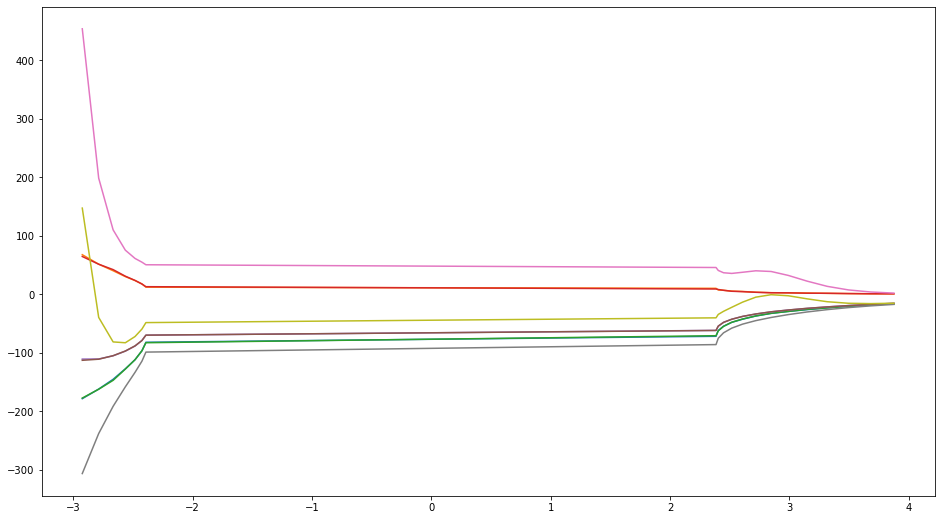

In [22]:
import matplotlib.pyplot as plt
d_potentials = [sum(x) for x in zip(da_energies, dr_energies)]
plt.figure(figsize=(16,9))
cut = 0
plt.plot(distances, a_energies, label="Grid LJa")
plt.plot(distances, r_energies, label="Grid LJr")
plt.plot(distances, da_energies, label="Direct LJa")
plt.plot(distances, dr_energies, label="Direct LJr")
plt.plot(distances, potentials, label="Grid LJ Potential")
plt.plot(distances, d_potentials, label="Direct LJ Potential")
plt.plot(distances[cut:], ljr_actual[cut:], label="LJr Actual")
plt.plot(distances[cut:], lja_actual[cut:], label="LJa Actual")
plt.plot(distances, lj_actual, label="LJ Actual")
add_vertical_lines(get_sigmas(rec_grid))
plt.xlabel("Distance Å")
plt.ylabel("Energy KJ/Mol")
plt.ylim(-50,24)
plt.axvline(x=2.6666947806561088, linestyle='--', color='red')
plt.text(2.2, 20, f"{2.666:.2f}A", rotation=0, verticalalignment='center', color="red", backgroundcolor="black", size=12)
plt.legend()
plt.show()

In [52]:
import matplotlib.pyplot as plt
d_potentials = [sum(x) for x in zip(da_energies, dr_energies)]
plt.figure(figsize=(16,9))
cut = 0
plt.plot(distances_adjusted, a_energies, label="Grid LJa")
plt.plot(distances_adjusted, r_energies, label="Grid LJr")
# plt.plot(distances_adjusted, da_energies, label="Direct LJa")
# plt.plot(distances_adjusted, dr_energies, label="Direct LJr")
plt.plot(distances_adjusted, potentials, label="Grid LJ Potential")
# plt.plot(distances_adjusted, d_potentials, label="Direct LJ Potential")
plt.plot(distances_adjusted[cut:], ljr_actual[cut:], label="LJr Actual")
plt.plot(distances_adjusted[cut:], lja_actual[cut:], label="LJa Actual")
plt.plot(distances_adjusted, lj_actual, label="LJ Actual")
add_vertical_lines(get_sigmas(rec_grid))
plt.xlabel("Distance Å")
plt.ylabel("Energy KJ/Mol")
plt.ylim(-150,50)
plt.axvline(x=2.6666947806561088, linestyle='--', color='red')
plt.text(2.2, 20, f"{2.666:.2f}A", rotation=0, verticalalignment='center', color="red", backgroundcolor="black", size=12)
plt.legend()
plt.show()

NameError: name 'distances_adjusted' is not defined

<Figure size 1152x648 with 0 Axes>

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

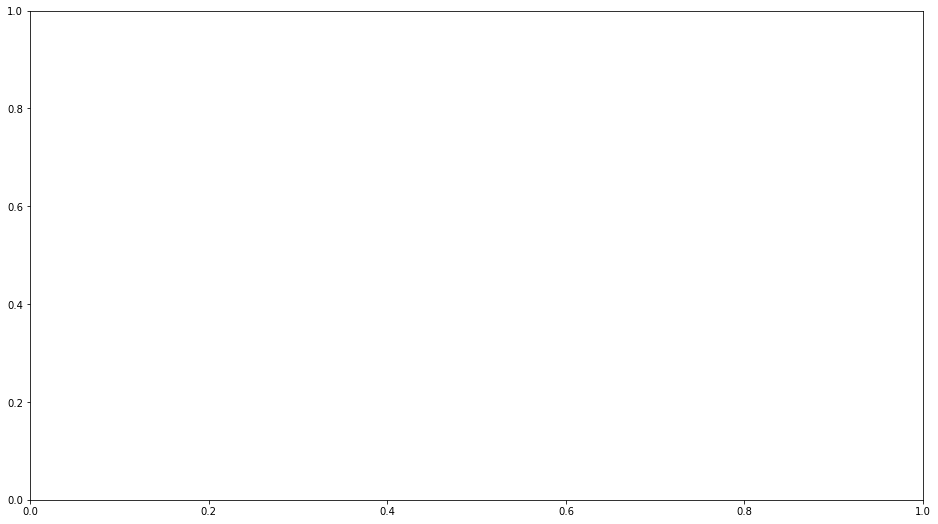

In [51]:
import matplotlib.pyplot as plt
d_potentials = [sum(x) for x in zip(da_energies, dr_energies)]
plt.figure(figsize=(16,9))
cut = 0
plt.plot(dist_approved, a_energies, label="Grid LJa")
plt.plot(dist_approved, r_energies, label="Grid LJr")
# plt.plot(dist_approved, da_energies, label="Direct LJa")
# plt.plot(dist_approved, dr_energies, label="Direct LJr")
plt.plot(dist_approved, potentials, label="Grid LJ Potential")
# plt.plot(dist_approved, d_potentials, label="Direct LJ Potential")
plt.plot(dist_approved[cut:], ljr_actual[cut:], label="LJr Actual")
plt.plot(dist_approved[cut:], lja_actual[cut:], label="LJa Actual")
plt.plot(dist_approved, lj_actual, label="LJ Actual")
# add_vertical_lines(get_sigmas(rec_grid))
plt.xlabel("Distance Å")
plt.ylabel("Energy KJ/Mol")
plt.ylim(-150,50)
plt.axvline(x=0, linestyle='--', color='red')
plt.text(0, 20, f"{2.666:.2f}A", rotation=0, verticalalignment='center', color="red", backgroundcolor="black", size=12)
plt.text(0, 20, f"Native", rotation=0, verticalalignment='center', color="red", backgroundcolor="black", size=12)
plt.legend()
plt.show()

In [ ]:
add_vertical_lines(get_sigmas(rec_grid))

In [ ]:
def write_lig_dx(FN, data, grid):
    """
    Writes a grid in dx format
    """
    n_points = data['counts'][0] * data['counts'][1] * data['counts'][2]
    if FN.endswith('.dx'):
        F = open(FN, 'w')

    F.write("""object 1 class gridpositions counts {0[0]} {0[1]} {0[2]}
origin {1[0]} {1[1]} {1[2]}
delta {2[0]} 0.0 0.0
delta 0.0 {2[1]} 0.0
delta 0.0 0.0 {2[2]}
object 2 class gridconnections counts {0[0]} {0[1]} {0[2]}
object 3 class array type double rank 0 items {3} data follows
""".format(data['counts'], data['origin'], data['spacing'], n_points))

    for start_n in range(0, len(grid.ravel()), 3):
        F.write(' '.join(['%6e' % c
                        for c in grid.ravel()[start_n:start_n + 3]]) + '\n')

    F.write('object 4 class field\n')
    F.write('component "positions" value 1\n')
    F.write('component "connections" value 2\n')
    F.write('component "data" value 3\n')
    F.close()

In [ ]:
def write(FN, data, grid, multiplier=None):
    """
    Writes a grid in dx or netcdf format.
    The multiplier affects the origin and spacing.
    """
    if multiplier is not None:
      data_n = {
        'origin': multiplier * data['origin'],
        'counts': data['counts'],
        'spacing': multiplier * data['spacing'],
        'vals': grid
      }
    else:
      data_n = data
    if FN.endswith('.nc'):
        print('skip')
#       _write_nc(FN, data_n)
    elif FN.endswith('.dx') or FN.endswith('.dx.gz'):
      write_lig_dx(FN, data_n, grid)
    else:
      raise Exception('File type not supported')

In [ ]:
import bpmfwfft.IO as IO
data = {"origin": lig_grid._grid['origin'], "spacing": lig_grid._spacing, "counts": lig_grid._grid["counts"]}
FN=f"{ppi_path}/2.redock/4.receptor_grid/2OOB_A:B/ljr_score.dx"
write(FN, data, l_ones)

In [49]:
print(lig_grid._crd.min(axis=0), rec_grid._crd.max(axis=0))

[35.8910512 45.6171129 23.3805658] [69.5144563 68.5886631 69.5205898]


In [43]:
lig_grid._crd.max(axis=0)

array([70.2671795, 67.1065984, 54.911315 ])

In [51]:
lig_grid._crd[34]

array([64.6702199, 56.5483709, 48.8178034])

In [50]:
rec_grid._crd[107]

masked_array(data=[63.0950694, 58.3378962, 48.8729138],
             mask=False,
       fill_value=1e+20)

In [85]:
native_trans

masked_array(data=[32.5, 42.5, 21.5],
             mask=False,
       fill_value=1e+20)

In [109]:
z

array([28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
       41., 42., 43., 44., 45., 46., 47.])

In [90]:
native_trans[2]/.5

43.0

In [99]:
lig_grid._crd[34][2] > rec_grid._crd[107][2]

False

In [100]:
lig_grid._crd[34][2]

43.8178034

In [101]:
rec_grid._crd[107][2]

48.8729138

In [ ]:
distances

In [135]:
distances_adjusted = np.concatenate([np.array(distances)[:15],2.384646106485934+np.array(distances)[15:]+2.384646106485934])

In [136]:
distances_adjusted

array([7.44701837, 6.97516826, 6.50752348, 6.04506009, 5.58906442,
       5.14125769, 4.70397919, 4.28045673, 3.87520315, 3.49457995,
       3.14753533, 2.84637809, 2.60705923, 2.44778419, 2.38464611,
       2.34412693, 2.20485928, 1.98160395, 1.69259017, 1.35447376])

In [26]:
z-43

array([29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
       42., 43., 44., 45., 46., 47., 48.])

In [50]:
dist_approved = -1*z*lig_grid._spacing[0]+21.5

In [ ]:
occ[test_range.astype(int)]

In [43]:
inds = test_range.astype(int)

In [52]:
occ[135,174,97]

35.00000000000021

In [42]:
test_range.shape

(20, 3)

In [46]:
inds

array([[135, 174,  72],
       [135, 174,  73],
       [135, 174,  74],
       [135, 174,  75],
       [135, 174,  76],
       [135, 174,  77],
       [135, 174,  78],
       [135, 174,  79],
       [135, 174,  80],
       [135, 174,  81],
       [135, 174,  82],
       [135, 174,  83],
       [135, 174,  84],
       [135, 174,  85],
       [135, 174,  86],
       [135, 174,  87],
       [135, 174,  88],
       [135, 174,  89],
       [135, 174,  90],
       [135, 174,  91]])

In [22]:
import netCDF4 as nc
import numpy as np

fft_file = nc.Dataset("/media/jim/fft_data/FFT_PPI/2.redock/5.fft_sampling/2OOB_A:B/least_squares_test.nc")

In [35]:
def rmsd(P: np.ndarray, Q: np.ndarray, **kwargs) -> float:
    """
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    Parameters
    ----------
    V : array
        (N,D) matrix, where N is points and D is dimension.
    W : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
        Root-mean-square deviation between the two vectors
    """
    diff = P - Q
    return np.sqrt((diff * diff).sum() / P.shape[0])

def translate(crd, displacement):
    """
    translate the ligand by displacement in Angstroms
    """
    for atom_ind in range(len(crd)):
        self._crd[atom_ind] += displacement


In [24]:
fft_file.variables.keys()

dict_keys(['rec_positions', 'lig_positions', 'lig_com', 'volume', 'nr_grid_points', 'exponential_sums', 'log_of_divisors', 'mean_energy', 'min_energy', 'energy_std', 'resampled_energies', 'resampled_trans_vectors', 'native_pose_energy', 'native_crd', 'native_translation', 'LJ_resampled_energies', 'LJ_resampled_trans_vectors', 'LJ_native_pose_energy', 'no_sasa_resampled_energies', 'no_sasa_resampled_trans_vectors', 'no_sasa_native_pose_energy', 'sasa_resampled_energies', 'sasa_resampled_trans_vectors', 'sasa_native_pose_energy', 'lj_sigma_scaling_factor', 'x', 'y', 'z', 'd0', 'd1', 'd2', 'spacing', 'counts', 'origin', 'rec_core_scaling', 'rec_surface_scaling', 'rec_metal_scaling'])

In [36]:
esasa = fft_file.variables["resampled_energies"][:]
tsasa = fft_file.variables["resampled_trans_vectors"][:]

enosasa = fft_file.variables["no_sasa_resampled_energies"][:]
tnosasa = fft_file.variables["no_sasa_resampled_trans_vectors"][:]

In [26]:
native_crd = fft_file.variables["native_translation"][:]
native_crd

masked_array(data=[59, 85, 40],
             mask=False,
       fill_value=999999)

In [37]:
import copy
rmsd1 = []
rmsd2 = []
# result = map(cat_dictionaries, rec_grid._prmtop, lig_grid._prmtop)
test_range = tsasa[0]
test_range2 = tnosasa[0]
for v,vector in enumerate(test_range[:100]):
    vector_crd = (np.array(vector).transpose()*lig_grid._spacing[0])
    vector = vector.astype(int)
    x,y,z = vector
    lig_grid._move_ligand_to_lower_corner()
    print(vector, vector_crd)
    lig_grid.translate_ligand(vector_crd)
    com_grid = cat_grids(rec_grid, lig_grid)
    rmsd_to_native = rmsd(ref, lig_grid._crd)
    # if rmsd_to_native < 5.:
    #     # colors.append([255, 0, 0])
    #     colors.append("red")
    # else:
    #     # colors.append([0, 255, 255])
    #     colors.append("black")
    num = str(vector[2]).replace(".", "_")
    rmsd1.append(rmsd_to_native)

for v,vector in enumerate(test_range2[:100]):
    vector_crd = (np.array(vector).transpose()*lig_grid._spacing[0])
    vector = vector.astype(int)
    x,y,z = vector
    lig_grid._move_ligand_to_lower_corner()
    print(vector, vector_crd)
    lig_grid.translate_ligand(vector_crd)
    com_grid = cat_grids(rec_grid, lig_grid)
    rmsd_to_native = rmsd(ref, lig_grid._crd)
    # if rmsd_to_native < 5.:
    #     # colors.append([255, 0, 0])
    #     colors.append("red")
    # else:
    #     # colors.append([0, 255, 255])
    #     colors.append("black")
    num = str(vector[2]).replace(".", "_")
    rmsd2.append(rmsd_to_native)
    # com_grid.write_pdb(f'{home}/src/p39/fftanalysis/test_systems/3.analysis/1.pdbs/{system}/complex/complex_{vector[2]:03}.pdb', "w")
    # lig_grid.write_pdb(f'{home}/src/p39/fftanalysis/test_systems/3.analysis/1.pdbs/{system}/ligand/trans{vector[2]:03}.pdb', "w")
    # rec_grid.write_pdb(f'{home}/src/p39/fftanalysis/test_systems/3.analysis/1.pdbs/{system}/receptor/rec.pdb', "w")
    # if rec_grid._crd.mean(axis=0)[2] > lig_grid._crd.mean(axis=0)[2]:
    #     distances.append(_distance(lig_grid._crd.mean(axis=0),rec_grid._crd.mean(axis=0)))
    # else:
    #     distances.append(-1*(_distance(lig_grid._crd.mean(axis=0),rec_grid._crd.mean(axis=0))))
#     a_energies.append(lja_energy[x,y,z])
#     r_energies.append(ljr_energy[x,y,z])
#     potentials.append(lja_energy[x,y,z]+ljr_energy[x,y,z])
#     charges = lig_grid.get_charges()
#     lja_charge = charges["A_LJ_CHARGE"]
#     ljr_charge = charges["R_LJ_CHARGE"]
#     e_charges = charges["CHARGE_E_UNIT"]
#     zeros = np.zeros(lja_charge.shape)
#     lja_charges = {"A_LJ_CHARGE": lja_charge, "R_LJ_CHARGE": zeros, "CHARGE_E_UNIT": zeros}
#     ljr_charges = {"A_LJ_CHARGE": zeros, "R_LJ_CHARGE": ljr_charge, "CHARGE_E_UNIT": zeros}
#     dr_energies.append(rec_grid.direct_energy(lig_grid._crd, ljr_charges))
#     da_energies.append(rec_grid.direct_energy(lig_grid._crd, lja_charges))
#     a,b,c = lj_components(rec_grid, lig_grid)
#     ljr_actual.append(a)
#     lja_actual.append(b)
#     lj_actual.append(c)
#     output.append(f"Distance: {_distance(lig_grid._crd[0],rec_grid._crd[0]):.1f} Angstroms, LJa Energy: grid: {lja_energy[x,y,z]:.5f} direct: {da_energies[-1]:.5f}, LJr Energy: grid: {ljr_energy[x,y,z]:.5f} direct: {dr_energies[-1]:.5f}, LJ Potential: {lja_energy[x,y,z]+ljr_energy[x,y,z]:.5f}")
# for line in output:
#     print(line)

Ligand translated by [0. 0. 0.]
[2.6410512 2.3671129 2.3805658]
[66 85 43] [33.  42.5 21.5]
Ligand translated by [-33.  -42.5 -21.5]
[2.6410512 2.3671129 2.3805658]
[62 86 41] [31.  43.  20.5]
Ligand translated by [-31.  -43.  -20.5]
[2.6410512 2.3671129 2.3805658]
[65 86 43] [32.5 43.  21.5]
Ligand translated by [-32.5 -43.  -21.5]
[2.6410512 2.3671129 2.3805658]
[64 85 42] [32.  42.5 21. ]
Ligand translated by [-32.  -42.5 -21. ]
[2.6410512 2.3671129 2.3805658]
[63 85 42] [31.5 42.5 21. ]
Ligand translated by [-31.5 -42.5 -21. ]
[2.6410512 2.3671129 2.3805658]
[66 85 44] [33.  42.5 22. ]
Ligand translated by [-33.  -42.5 -22. ]
[2.6410512 2.3671129 2.3805658]
[67 85 44] [33.5 42.5 22. ]
Ligand translated by [-33.5 -42.5 -22. ]
[2.6410512 2.3671129 2.3805658]
[68 86 45] [34.  43.  22.5]
Ligand translated by [-34.  -43.  -22.5]
[2.6410512 2.3671129 2.3805658]
[66 87 44] [33.  43.5 22. ]
Ligand translated by [-33.  -43.5 -22. ]
[2.6410512 2.3671129 2.3805658]
[67 86 44] [33.5 43.  22. ]

In [38]:
rmsd3 = [] 
tsasaonly = fft_file.variables["sasa_resampled_trans_vectors"][:]
test_range3 = tsasaonly[0]
for v,vector in enumerate(test_range3[:100]):
    vector_crd = (np.array(vector).transpose()*lig_grid._spacing[0])
    vector = vector.astype(int)
    x,y,z = vector
    lig_grid._move_ligand_to_lower_corner()
    print(vector, vector_crd)
    lig_grid.translate_ligand(vector_crd)
    com_grid = cat_grids(rec_grid, lig_grid)
    rmsd_to_native = rmsd(ref, lig_grid._crd)
    # if rmsd_to_native < 5.:
    #     # colors.append([255, 0, 0])
    #     colors.append("red")
    # else:
    #     # colors.append([0, 255, 255])
    #     colors.append("black")
    num = str(vector[2]).replace(".", "_")
    rmsd3.append(rmsd_to_native)

Ligand translated by [-15.5 -24.5 -23. ]
[2.6410512 2.3671129 2.3805658]
[65 86 46] [32.5 43.  23. ]
Ligand translated by [-32.5 -43.  -23. ]
[2.6410512 2.3671129 2.3805658]
[65 85 46] [32.5 42.5 23. ]
Ligand translated by [-32.5 -42.5 -23. ]
[2.6410512 2.3671129 2.3805658]
[66 86 46] [33. 43. 23.]
Ligand translated by [-33. -43. -23.]
[2.6410512 2.3671129 2.3805658]
[64 87 45] [32.  43.5 22.5]
Ligand translated by [-32.  -43.5 -22.5]
[2.6410512 2.3671129 2.3805658]
[66 85 46] [33.  42.5 23. ]
Ligand translated by [-33.  -42.5 -23. ]
[2.6410512 2.3671129 2.3805658]
[64 86 45] [32.  43.  22.5]
Ligand translated by [-32.  -43.  -22.5]
[2.6410512 2.3671129 2.3805658]
[63 84 45] [31.5 42.  22.5]
Ligand translated by [-31.5 -42.  -22.5]
[2.6410512 2.3671129 2.3805658]
[64 85 45] [32.  42.5 22.5]
Ligand translated by [-32.  -42.5 -22.5]
[2.6410512 2.3671129 2.3805658]
[66 84 46] [33. 42. 23.]
Ligand translated by [-33. -42. -23.]
[2.6410512 2.3671129 2.3805658]
[64 84 45] [32.  42.  22.5]
Li

In [39]:
rmsd4 = [] 
tLJonly = fft_file.variables["LJ_resampled_trans_vectors"][:]
test_range4 = tLJonly[0]
for v,vector in enumerate(test_range4[:100]):
    vector_crd = (np.array(vector).transpose()*lig_grid._spacing[0])
    vector = vector.astype(int)
    x,y,z = vector
    lig_grid._move_ligand_to_lower_corner()
    print(vector, vector_crd)
    lig_grid.translate_ligand(vector_crd)
    com_grid = cat_grids(rec_grid, lig_grid)
    rmsd_to_native = rmsd(ref, lig_grid._crd)
    # if rmsd_to_native < 5.:
    #     # colors.append([255, 0, 0])
    #     colors.append("red")
    # else:
    #     # colors.append([0, 255, 255])
    #     colors.append("black")
    num = str(vector[2]).replace(".", "_")
    rmsd4.append(rmsd_to_native)

Ligand translated by [-33.  -43.5 -21.5]
[2.6410512 2.3671129 2.3805658]
[133 159   0] [66.5 79.5  0. ]
Ligand translated by [-66.5 -79.5   0. ]
[2.6410512 2.3671129 2.3805658]
[132 159   0] [66.  79.5  0. ]
Ligand translated by [-66.  -79.5   0. ]
[2.6410512 2.3671129 2.3805658]
[133 158   0] [66.5 79.   0. ]
Ligand translated by [-66.5 -79.    0. ]
[2.6410512 2.3671129 2.3805658]
[133 159   1] [66.5 79.5  0.5]
Ligand translated by [-66.5 -79.5  -0.5]
[2.6410512 2.3671129 2.3805658]
[131 159   0] [65.5 79.5  0. ]
Ligand translated by [-65.5 -79.5   0. ]
[2.6410512 2.3671129 2.3805658]
[132 158   0] [66. 79.  0.]
Ligand translated by [-66. -79.   0.]
[2.6410512 2.3671129 2.3805658]
[133 157   0] [66.5 78.5  0. ]
Ligand translated by [-66.5 -78.5   0. ]
[2.6410512 2.3671129 2.3805658]
[132 159   1] [66.  79.5  0.5]
Ligand translated by [-66.  -79.5  -0.5]
[2.6410512 2.3671129 2.3805658]
[133 158   1] [66.5 79.   0.5]
Ligand translated by [-66.5 -79.   -0.5]
[2.6410512 2.3671129 2.380565

In [51]:
rmsd5 = [] 
teonly = fft_file.variables["electrostatic_trans_vectors"][:]
test_range5 = teonly[0]
for v,vector in enumerate(test_range5[:100]):
    vector_crd = (np.array(vector).transpose()*lig_grid._spacing[0])
    vector = vector.astype(int)
    x,y,z = vector
    lig_grid._move_ligand_to_lower_corner()
    print(vector, vector_crd)
    lig_grid.translate_ligand(vector_crd)
    com_grid = cat_grids(rec_grid, lig_grid)
    rmsd_to_native = rmsd(ref, lig_grid._crd)
    # if rmsd_to_native < 5.:
    #     # colors.append([255, 0, 0])
    #     colors.append("red")
    # else:
    #     # colors.append([0, 255, 255])
    #     colors.append("black")
    num = str(vector[2]).replace(".", "_")
    rmsd5.append(rmsd_to_native)

KeyError: 'electrostatic_trans_vectors'

In [40]:
print(np.mean(rmsd1), np.mean(rmsd2), np.mean(rmsd3), np.mean(rmsd4))

5.585931036465797 5.818973371562047 1.4655353384354617 53.97297604288289


In [53]:
fft_file.variables.keys()

dict_keys(['rec_positions', 'lig_positions', 'lig_com', 'volume', 'nr_grid_points', 'exponential_sums', 'log_of_divisors', 'mean_energy', 'min_energy', 'energy_std', 'resampled_energies', 'resampled_trans_vectors', 'native_pose_energy', 'native_crd', 'native_translation', 'LJ_resampled_energies', 'LJ_resampled_trans_vectors', 'LJ_native_pose_energy', 'no_sasa_resampled_energies', 'no_sasa_resampled_trans_vectors', 'no_sasa_native_pose_energy', 'sasa_resampled_energies', 'sasa_resampled_trans_vectors', 'sasa_native_pose_energy', 'lj_sigma_scaling_factor', 'x', 'y', 'z', 'd0', 'd1', 'd2', 'spacing', 'counts', 'origin', 'rec_core_scaling', 'rec_surface_scaling', 'rec_metal_scaling'])

In [ ]:
rmsd1

In [1]:
ref

NameError: name 'ref' is not defined

In [13]:
tar

array([[33.4243302,  5.5029521, 33.7942128],
       [32.6219945,  5.5887321, 33.1811242],
       [33.7618976,  6.438872 , 33.9911323],
       ...,
       [ 9.1026191, 20.7347933, 14.8396354],
       [ 9.8092443, 20.8140126, 15.8695214],
       [ 8.1733087, 19.9101332, 14.7202497]])

In [25]:
tsasa[0]

masked_array(
  data=[[ 66,  85,  43],
        [ 65,  86,  43],
        [ 66,  85,  44],
        ...,
        [ 13,  92,  47],
        [ 68,  93,  43],
        [105,  80,  63]],
  mask=False,
  fill_value=999999)

In [36]:
test_range

masked_array(
  data=[[ 66,  85,  43],
        [ 65,  86,  43],
        [ 66,  85,  44],
        ...,
        [ 13,  92,  47],
        [ 68,  93,  43],
        [105,  80,  63]],
  mask=False,
  fill_value=999999)

In [37]:
test_range2

masked_array(
  data=[[ 66,  85,  43],
        [ 65,  86,  43],
        [ 66,  85,  44],
        ...,
        [ 73,  88,  43],
        [ 40,  70, 115],
        [ 86,  29,  80]],
  mask=False,
  fill_value=999999)

In [42]:
print(np.mean(rmsd1), np.mean(rmsd2), np.mean(rmsd3))

1.807471805479211 1.8074718054792107 1.807471805479211


In [33]:
import numpy as np
a_matrix = np.array([[ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [-0.34257698, -0.34257698, -0.34257698,  0.15742302,  0.15742302,
         0.15742302,  0.15742302,  0.15742302,  0.65742302,  0.15742302],
       [-0.03675604, -0.03675604,  0.46324396, -0.03675604, -0.03675604,
         0.46324396,  0.46324396, -0.53675604, -0.03675604, -0.03675604],
       [-0.46137238,  0.03862762,  0.03862762, -0.46137238,  0.03862762,
        -0.46137238,  0.03862762,  0.03862762,  0.03862762,  0.53862762],
       [ 0.11735899,  0.11735899,  0.11735899,  0.02478201,  0.02478201,
         0.02478201,  0.02478201,  0.02478201,  0.43220503,  0.02478201],
       [ 0.01259177,  0.01259177, -0.15869672, -0.00578625, -0.00578625,
         0.07292526,  0.07292526, -0.08449776, -0.02416427, -0.00578625],
       [ 0.15805556, -0.01323293, -0.01323293, -0.07263063,  0.00608088,
        -0.07263063,  0.00608088,  0.00608088,  0.02539469,  0.08479239],
       [ 0.00135101,  0.00135101,  0.21459497,  0.00135101,  0.00135101,
         0.21459497,  0.21459497,  0.28810705,  0.00135101,  0.00135101],
       [ 0.01695822, -0.0014198 ,  0.01789401,  0.01695822, -0.0014198 ,
        -0.21372797,  0.01789401, -0.02073361, -0.0014198 , -0.01979782],
       [ 0.21286447,  0.00149209,  0.00149209,  0.21286447,  0.00149209,
         0.21286447,  0.00149209,  0.00149209,  0.00149209,  0.29011972]])

b_vector = np.array([971.74751505,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ])

In [1]:
import numpy as np
from highs import Highs

# Define the inputs
a_matrix = np.array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
                    [-0.34257698, -0.34257698, -0.34257698, 0.15742302, 0.15742302,
                     0.15742302, 0.15742302, 0.15742302, 0.65742302, 0.15742302],
                    [-0.03675604, -0.03675604, 0.46324396, -0.03675604, -0.03675604,
                     0.46324396, 0.46324396, -0.53675604, -0.03675604, -0.03675604],
                    [-0.46137238, 0.03862762, 0.03862762, -0.46137238, 0.03862762,
                     -0.46137238, 0.03862762, 0.03862762, 0.03862762, 0.53862762],
                    [0.11735899, 0.11735899, 0.11735899, 0.02478201, 0.02478201,
                     0.02478201, 0.02478201, 0.02478201, 0.43220503, 0.02478201],
                    [0.01259177, 0.01259177, -0.15869672, -0.00578625, -0.00578625,
                     0.07292526, 0.07292526, -0.08449776, -0.02416427, -0.00578625],
                    [0.15805556, -0.01323293, -0.01323293, -0.07263063, 0.00608088,
                     -0.07263063, 0.00608088, 0.00608088, 0.02539469, 0.08479239],
                    [0.00135101, 0.00135101, 0.21459497, 0.00135101, 0.00135101,
                     0.21459497, 0.21459497, 0.28810705, 0.00135101, 0.00135101],
                    [0.01695822, -0.0014198, 0.01789401, 0.01695822, -0.0014198,
                     -0.21372797, 0.01789401, -0.02073361, -0.0014198, -0.01979782],
                    [0.21286447, 0.00149209, 0.00149209, 0.21286447, 0.00149209,
                     0.21286447, 0.00149209, 0.00149209, 0.00149209, 0.29011972]])

b_vector = np.array([971.74751505, 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Number of variables and equations
n_variables = a_matrix.shape[1]
n_equations = a_matrix.shape[0]

# Objective function coefficients (zeros because we only have constraints)
c = np.zeros(n_variables)

# Coefficients matrix
A = np.concatenate((a_matrix, -np.eye(n_variables)), axis=0)

# Upper bounds (constraint on the sum)
b = np.concatenate((b_vector, np.zeros(n_variables)))

# Equality constraints (to enforce non-negativity)
A_eq = np.ones((1, n_variables))
b_eq = np.array([1.0])

# Create a Highs LP solver instance
solver = Highs()

# Set the solver options
solver.setHighsOptionValue("solver", "highs")

# Add constraints to the solver
solver.addRows(
    num_new_rows=n_equations,
    row_lb=-solver.infinite_bound,
    row_ub=b,
    row_type=["L"] * n_equations,
    row_wise_matrix=A,  # corrected argument name
)

# Add equality constraint to the solver
solver.addRows(
    num_new_rows=1,
    row_lb=b_eq,
    row_ub=b_eq,
    row_type=["E"],
    row_wise_matrix=A_eq,  # corrected argument name
)

# Set the objective sense (minimize)
solver.setObjectiveSense("minimize")

# Optimize the LP problem
status = solver.run()

# Check if optimization was successful
if status.value == 0:
    # Get the solution
    solution = solver.getSolution()

    # Display the solution
    print("Solution:")
    for i in range(n_variables):
        print(f"x{i+1} = {solution[i]}")
else:
    print("No feasible solution found.")


ModuleNotFoundError: No module named 'highs'

In [17]:
from scipy.optimize import nnls

result_nnls = nnls(a_matrix, b_vector)
result_linalg = np.linalg.solve(a_matrix, b_vector)

TypeError: failed in converting 1st argument `a' of __nnls.nnls to C/Fortran array

In [14]:
print(result_nnls[0], "sum:", result_nnls[0].sum())

[ 18.2150303  250.72596286  17.29455903  40.55669198 599.73115433
   3.67080593  38.33126871   0.           0.           0.        ] sum: 968.5254731361083


In [13]:
print(result_linalg, "sum:", result_linalg.sum())

[  23.63629365  155.01176582   22.49107151   11.28114642  916.01511191
    5.51873563   10.33345091  -33.09192301 -104.81172601  -34.63641179] sum: 971.7475150499996


In [5]:
import highs

ModuleNotFoundError: No module named 'highs'

In [6]:
import numpy as np
from scipy.linalg import solve as scipy_solve
from numpy.linalg import solve as numpy_solve
from scipy.optimize import linprog, nnls
from sympy import symbols, Eq, solve as sympy_solve

# Define the inputs
a_matrix = np.array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
                    [-0.34257698, -0.34257698, -0.34257698, 0.15742302, 0.15742302,
                     0.15742302, 0.15742302, 0.15742302, 0.65742302, 0.15742302],
                    [-0.03675604, -0.03675604, 0.46324396, -0.03675604, -0.03675604,
                     0.46324396, 0.46324396, -0.53675604, -0.03675604, -0.03675604],
                    [-0.46137238, 0.03862762, 0.03862762, -0.46137238, 0.03862762,
                     -0.46137238, 0.03862762, 0.03862762, 0.03862762, 0.53862762],
                    [0.11735899, 0.11735899, 0.11735899, 0.02478201, 0.02478201,
                     0.02478201, 0.02478201, 0.02478201, 0.43220503, 0.02478201],
                    [0.01259177, 0.01259177, -0.15869672, -0.00578625, -0.00578625,
                     0.07292526, 0.07292526, -0.08449776, -0.02416427, -0.00578625],
                    [0.15805556, -0.01323293, -0.01323293, -0.07263063, 0.00608088,
                     -0.07263063, 0.00608088, 0.00608088, 0.02539469, 0.08479239],
                    [0.00135101, 0.00135101, 0.21459497, 0.00135101, 0.00135101,
                     0.21459497, 0.21459497, 0.28810705, 0.00135101, 0.00135101],
                    [0.01695822, -0.0014198, 0.01789401, 0.01695822, -0.0014198,
                     -0.21372797, 0.01789401, -0.02073361, -0.0014198, -0.01979782],
                    [0.21286447, 0.00149209, 0.00149209, 0.21286447, 0.00149209,
                     0.21286447, 0.00149209, 0.00149209, 0.00149209, 0.29011972]])

b_vector = np.array([971.74751505, 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Method 1: NumPy's linalg.solve
x_numpy = numpy_solve(a_matrix, b_vector)

# Method 2: SciPy's linalg.solve
x_scipy = scipy_solve(a_matrix, b_vector)

# Method 3: SymPy's solve
x_sympy = symbols('x1:11')
eqs = [Eq(sum(a_matrix[i] * x_sympy), b_vector[i]) for i in range(len(b_vector))]
solutions_sympy = sympy_solve(eqs, x_sympy)

from scipy.optimize import minimize

# Method 4: Linear programming with SLSQP method
c_lp = np.zeros(a_matrix.shape[1])  # Objective function coefficients
A_eq_lp = np.ones((1, a_matrix.shape[1]))  # Equality constraint matrix
b_eq_lp = np.array([1.0])  # Equality constraint vector
bounds_lp = [(0, None)] * a_matrix.shape[1]  # Bounds on variables (non-negative)

result_lp = minimize(
    fun=lambda x: np.dot(x, c_lp),  # Linear objective function
    x0=np.zeros(a_matrix.shape[1]),  # Initial guess
    constraints={
        'type': 'eq',
        'fun': lambda x: np.dot(A_eq_lp, x) - b_eq_lp  # Equality constraint
    },
    bounds=bounds_lp,  # Bounds on variables
    method='SLSQP'
)
x_lp = result_lp.x


# Method 5: Non-negative least squares
x_nnls, _ = nnls(a_matrix, b_vector)

# Display the results
print("Results:")
print("Method 1: NumPy's linalg.solve")
print(x_numpy)
print("\nMethod 2: SciPy's linalg.solve")
print(x_scipy)
print("\nMethod 3: SymPy's solve")
for var, sol in solutions_sympy.items():
    print(f"{var} = {sol.evalf()}")
print("\nMethod 4: Linear programming")
print(x_lp)
print("\nMethod 5: Non-negative least squares")
print(x_nnls)


Results:
Method 1: NumPy's linalg.solve
[  23.63629365  155.01176582   22.49107151   11.28114642  916.01511191
    5.51873563   10.33345091  -33.09192301 -104.81172601  -34.63641179]

Method 2: SciPy's linalg.solve
[  23.63629365  155.01176582   22.49107151   11.28114642  916.01511191
    5.51873563   10.33345091  -33.09192301 -104.81172601  -34.63641179]

Method 3: SymPy's solve
x1 = 23.6362936531822
x10 = -34.6364117897137
x2 = 155.011765816660
x3 = 22.4910715148926
x4 = 11.2811464237486
x5 = 916.015111905252
x6 = 5.51873562794684
x7 = 10.3334509149733
x8 = -33.0919230083440
x9 = -104.811726008598

Method 4: Linear programming
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]

Method 5: Non-negative least squares
[ 18.2150303  250.72596286  17.29455903  40.55669198 599.73115433
   3.67080593  38.33126871   0.           0.           0.        ]


In [21]:
def test_taylor_constraints(solution, a_matrix, b_vector):
    # Evaluate the 1st and 2nd order Taylor approximations
    f = np.dot(a_matrix, solution) - b_vector
    grad_f = np.dot(a_matrix.T, f)
    hessian_f = np.dot(a_matrix.T, a_matrix)

    # Test the 1st order Taylor constraint
    print("f:", f, "grad_f:", grad_f)
    first_order_constraint = np.allclose(f, grad_f)

    # Test the 2nd order Taylor constraint
    second_order_constraint = np.allclose(f, np.dot(hessian_f, solution) + grad_f)


    # Return the results
    return first_order_constraint, second_order_constraint

# Example usage
solution = x_nnls  # Use the solution obtained from one of the methods
first_order, second_order = test_taylor_constraints(solution, a_matrix, b_vector)

# Print the results
print("1st Order Taylor Constraint:", first_order)
print("2nd Order Taylor Constraint:", second_order)

f: [-3.22204191e+00  9.35042883e+00 -5.95084420e+00  6.19056984e+00
  5.05008310e+01  5.68434189e-14 -8.61533067e-14  1.39531366e+01
 -7.88258347e-15  1.46437530e+01] grad_f: [-7.68274333e-13 -6.39644587e-13 -6.30915459e-13 -7.63833441e-13
 -6.56075888e-13 -7.38964445e-13 -6.33579994e-13  6.97656829e+00
  2.52504155e+01  7.32187663e+00]
f: [-3.22204191e+00  9.35042883e+00 -5.95084420e+00  6.19056984e+00
  5.05008310e+01  5.68434189e-14 -8.61533067e-14  1.39531366e+01
 -7.88258347e-15  1.46437530e+01] hession dot shit: [-1.02318154e-12 -9.09494702e-13 -6.82121026e-13 -9.09494702e-13
 -7.95807864e-13 -9.09494702e-13 -7.95807864e-13  6.97656829e+00
  2.52504155e+01  7.32187663e+00]
1st Order Taylor Constraint: False
2nd Order Taylor Constraint: False


In [12]:
print(f, np.dot(hessian_f, solution) + grad_f)

NameError: name 'f' is not defined